# Solution

In [1]:
!pip install datasets > /dev/null
!pip install transformers > /dev/null

In [2]:
import csv
import math
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch import LongTensor
from datasets import Dataset, DatasetDict, load_metric
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, 
    Trainer, TrainerCallback
)
from ipywidgets import interact

## Обработка данных

In [3]:
!gdown https://drive.google.com/uc?id=1nZWeSDHjrKtRliTgtGpr4CGwS9WzTHa7

Downloading...
From: https://drive.google.com/uc?id=1nZWeSDHjrKtRliTgtGpr4CGwS9WzTHa7
To: /content/data.csv
100% 925k/925k [00:00<00:00, 108MB/s]


In [4]:
def write(filename, content):
    with open(filename, "w", encoding="utf-8") as file:
        for i, entry in enumerate(content["D"]):
            if entry is None or isinstance(entry, float):
                continue
            file.write(entry)
            file.write("\n")

In [5]:
def stats(df, column):
    c = df.groupby(column)[column].count()
    c = (c / c.sum())
    #with pd.option_context('display.float_format', '{:0.3f}'.format):
    #    print(c / c.sum())
    c.plot.bar()

In [6]:
df = pd.read_csv("data.csv")
len(df["Description"].unique())

8684

In [7]:
df = df.rename(columns={"Category": "C", "Description": "D"})
df = df.drop_duplicates("D", keep=False)
df = df.replace("None", np.nan)
df = df.dropna()
df.rename(columns={"C": "Категория", "D": "Наименование"}).drop(columns={"product_id"})

,Наименование,Категория
0,"Kent HD Neo 4мг/0,3мг МРЦ 130р.",Сигареты
1,"Winston Silver 4мг/0,3мг МРЦ 125р.",Сигареты
2,Батончик Темпо,"Шоколад, шоколадные наборы"
3,"Parker & Simpson DUO Purple 6мг/0,5мг МРЦ 90р",Сигареты
4,"Моrе BY LD RED 30шт 9мг/0,6мг МРЦ 95р.",Сигареты
...,...,...
9072,Сигареты Philip Morris Breeze Mix МРЦ 119р.,Сигареты
9073,Сигареты Philip Morris Breeze Mix МРЦ ВСЕ,Сигареты
9074,"Настойка полусладкая Сиббиттер ВСЕ ВКУСЫ 0,5л.",Водка
9075,"Газ. напиток ""Милк Вэйвс"" ж/б ВСЕ ВКУСЫ 0,25",Соки - Воды


In [8]:
df.head()

,product_id,D,C
0,17542,"Kent HD Neo 4мг/0,3мг МРЦ 130р.",Сигареты
1,18589,"Winston Silver 4мг/0,3мг МРЦ 125р.",Сигареты
2,18429,Батончик Темпо,"Шоколад, шоколадные наборы"
3,19833,"Parker & Simpson DUO Purple 6мг/0,5мг МРЦ 90р",Сигареты
4,16066,"Моrе BY LD RED 30шт 9мг/0,6мг МРЦ 95р.",Сигареты


In [9]:
len(df["D"].unique())

8354

In [10]:
len(df["C"].unique())

26

In [11]:
df.to_csv("test.csv", index=False)

In [12]:
vocab = set()
sizes, words = [], []
with open("test.csv", encoding="utf-8") as file:
    reader = csv.reader(file)
    for i, (prod_id, info, class_id) in enumerate(reader):
        vocab.update(info.split())
        words.extend(info.split())
        sizes.append(info)
sizes = list(map(len, sizes))
mean = sum(sizes) / i
std = math.sqrt(sum((x - mean)**2 for x in sizes)/len(sizes))
print(f"vocab len: {len(vocab)}")
print(f"mean: {mean}")
print(f"std: {std}")
print(f"cv: {std/mean}")
print(len(words)/i)

vocab len: 8146
mean: 41.46157529327268
std: 12.347023122979765
cv: 0.29779435623573913
6.2847737610725405


In [13]:
@interact(category=df['C'].unique())
def f(category):
    return df.loc[df['C'] == category]

interactive(children=(Dropdown(description='category', options=('Сигареты', 'Шоколад, шоколадные наборы', 'Вод…

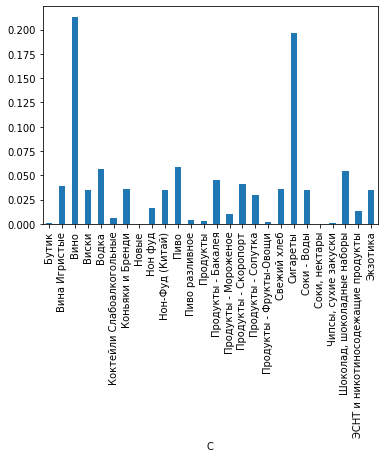

In [14]:
stats(df, "C")

In [15]:
df2 = df[df.C.isin([
    'Бутик', 'Новые', 'Нон фуд', 'Нон-Фуд (Китай)', 'Соки, нектары', 
    'Коньяки и Бренди', 'Продукты', 'Продукты - Скоропорт', 'Продукты - Сопутка',
    'Продукты - Фрукты-Овощи', 'Соки - Воды', 'Чипсы, сухие закуски',
    'Продукты - Мороженое'
])].drop_duplicates(subset="D")
df2.replace("", np.nan).dropna()
df2

,product_id,D,C
22,21440,Картофельные чипсы Натуралс с жареным луком,Продукты - Сопутка
24,19295,Ж/р Ментос Нежная мята,Продукты - Сопутка
25,19403,Фрикционная машина Быстрее ветра,Нон-Фуд (Китай)
44,14784,Коньяк Жемчужина Еревана 7 лет п/к 40% 0.5л,Коньяки и Бренди
55,18110,Плед с рукавами 150*200см,Нон фуд
...,...,...,...
9042,9000560,"Напиток сокосодержащий Фрупи 0,25л ВСЕ ВКУСЫ",Соки - Воды
9043,9000568,Лимонад Фреш Вейв'с ВСЕ ВКУСЫ,Соки - Воды
9044,9000564,Коктейль Изи Смузи ВСЕ ВКУСЫ,Соки - Воды
9075,9000478,"Газ. напиток ""Милк Вэйвс"" ж/б ВСЕ ВКУСЫ 0,25",Соки - Воды


In [16]:
#remaining[['D', 'C']].to_csv("remaining.csv", index=False, quoting=csv.QUOTE_ALL)
df3 = df2.copy()
df3.loc[(df3.C == "Нон фуд") | (df3.C == "Нон-Фуд (Китай)"), 'C'] = "Все остальное"
df3.loc[(df3.C == "Соки - Воды") & (df3.D.str.contains("сок|нектар", case=False) == True), 'C'] = "Соки, Нектары"
df3.loc[(df3.C == "Соки - Воды") & (df3.D.str.contains("вод|напиток|кола|лимонад|квас", case=False) == True), 'C'] = "Вода питьевая"
df3.loc[df3.D.str.contains("мороженое", case=False) == True, 'C'] = "Мороженое"
df3.loc[df3.D.str.contains("семе", case=False) == True, 'C'] = "Семечки"
df3.loc[df3.D.str.contains("орех|миндаль|фундук|арахис|фисташки", case=False) == True, 'C'] = "Орехи"
df3.loc[df3.D.str.contains("ж/р|драже|торт|леденцы|карамель|конфет", case=False) == True, 'C'] = "Шоколад и кондитерские изделия"
df3.loc[df3.D.str.contains("йогурт|сыр|творо|сливки|сметана|молоко|кефир|масло", case=False) == True, 'C'] = "Молоко и молочная продукция"
df3.loc[df3.D.str.contains("свин|сосиск|колбас|нарезк|ветчин|шпикачки|пивчик|грудинка|карбонад|говядина|джерки|сарде|буже", case=False) == True, 'C'] = "Мясные изделия"
df3.loc[df3.D.str.contains("сушен|вялен|соленая|холодн|кальмар|сельд|скумбри|горбуш|полосатик", case=False) == True, 'C'] = "Рыба вяленая, соленая и несоленая"
df3.loc[df3.D.str.contains("чипс|сухар|гренки", case=False) == True, 'C'] = "Чипсы, сухари, снеки"
df3.loc[df3.D.str.contains("виски", case=False) == True, 'C'] = "Виски"
df3.loc[df3.D.str.contains("коньяк", case=False) == True, 'C'] = "Коньяк"
df3.loc[df3.D.str.contains("бренди|арманьяк", case=False) == True, 'C'] = "Бренди"
df3.loc[df3.D.str.contains("соус|кетчуп|майо", case=False) == True, 'C'] = "Соусы"
class_map = [
    "Все остальное", "Соки, Нектары", "Вода питьевая", "Мясные изделия", "Молоко и молочная продукция", "Виски",
    "Чипсы, сухари, снеки", "Коньяк", "Бренди", "Шоколад и кондитерские изделия", "Рыба вяленая, соленая и несоленая",
    "Орехи", "Мороженое", "Семечки", "Соусы"
]
mapped = df3.loc[df3.C.isin(class_map)]
remaining = df3.loc[~df3.C.isin(class_map)]
write("remaining.txt", remaining)
mapped

,product_id,D,C
22,21440,Картофельные чипсы Натуралс с жареным луком,"Чипсы, сухари, снеки"
24,19295,Ж/р Ментос Нежная мята,Шоколад и кондитерские изделия
25,19403,Фрикционная машина Быстрее ветра,Все остальное
44,14784,Коньяк Жемчужина Еревана 7 лет п/к 40% 0.5л,Коньяк
55,18110,Плед с рукавами 150*200см,Все остальное
...,...,...,...
8997,9000541,Мороженое Коровка из Кореновки 400гр ВСЕ ВКУСЫ,Мороженое
9042,9000560,"Напиток сокосодержащий Фрупи 0,25л ВСЕ ВКУСЫ","Соки, Нектары"
9043,9000568,Лимонад Фреш Вейв'с ВСЕ ВКУСЫ,Вода питьевая
9075,9000478,"Газ. напиток ""Милк Вэйвс"" ж/б ВСЕ ВКУСЫ 0,25",Вода питьевая


In [17]:
remaining

,product_id,D,C
119,14063,Икра мойвы деликатесная подкопченная 165 г,Продукты - Скоропорт
195,14072,Коктейль молочный Чудо-Шоколад 3% 0.2л,Продукты - Скоропорт
278,19644,Продукт плавленый Фиетта классическая 55%,Продукты - Скоропорт
442,21303,Хинкали с говядиной,Продукты - Мороженое
451,18187,Арбуз,Продукты - Фрукты-Овощи
...,...,...,...
8629,9000263,Кашка ФрутоНяня ВСЕ ВКУСЫ 200мл,Соки - Воды
8643,9000223,Пюре Хайнц ВСЕ ВКУСЫ 90-100 гр,Соки - Воды
8667,9000517,Кукурузные палочки Читос ВСЕ ВКУСЫ 50-55гр,Продукты - Сопутка
8730,9000410,Детское шампанское Россия ВСЕ ВКУСЫ,Соки - Воды


In [18]:
!gdown https://drive.google.com/uc?id=16Y8F2_UGQ19Svr8hZdbSIhil2Dp0287g

Downloading...
From: https://drive.google.com/uc?id=16Y8F2_UGQ19Svr8hZdbSIhil2Dp0287g
To: /content/vsevolod.csv
100% 14.1k/14.1k [00:00<00:00, 17.2MB/s]


In [19]:
labeled = pd.read_csv("vsevolod.csv")
labeled = labeled.rename(columns={"data": "D", "label": "C"})
labeled.drop(labels='id', axis=1, inplace=True)
all = pd.merge(mapped, labeled, how="outer")
all

,product_id,D,C
0,21440.0,Картофельные чипсы Натуралс с жареным луком,"Чипсы, сухари, снеки"
1,19295.0,Ж/р Ментос Нежная мята,Шоколад и кондитерские изделия
2,19403.0,Фрикционная машина Быстрее ветра,Все остальное
3,14784.0,Коньяк Жемчужина Еревана 7 лет п/к 40% 0.5л,Коньяк
4,18110.0,Плед с рукавами 150*200см,Все остальное
...,...,...,...
1703,NaN,Коктейль молочный Чудо 200 мл. Все вкусы,Молоко и молочная продукция
1704,NaN,"Нап. б/а пастериз.Чай Липтон ВСЕ ВКУСЫ 0,5*12",Вода питьевая
1705,NaN,Коктейль ФрутоНяня молочный ВСЕ ВКУСЫ 200мл,Молоко и молочная продукция
1706,NaN,Кукурузные палочки Читос ВСЕ ВКУСЫ 50-55гр,"Чипсы, сухари, снеки"


In [20]:
print(len(all['C'].unique()))
all['C'].unique()

20


array(['Чипсы, сухари, снеки', 'Шоколад и кондитерские изделия',
       'Все остальное', 'Коньяк', 'Бренди', 'Мясные изделия',
       'Вода питьевая', 'Соусы', 'Соки, Нектары',
       'Молоко и молочная продукция', 'Рыба вяленая, соленая и несоленая',
       'Орехи', 'Мороженое', 'Виски', 'Семечки', 'Овощи свежие',
       'Фрукты свежие', 'Изделия хлебобулочные', 'Вино', 'Чай и кофе'],
      dtype=object)

In [21]:
write("data.txt", df2)

In [22]:
normal = df[df.C.isin([
    "Пиво", "Пиво разливное", "Водка", "Виски", "Вино", "Вина игристые", 
    "Свежий хлеб", "Сигареты", "ЭСНТ и никотиносодежащие продукты",
    "Шоколад, шоколадные наборы", "Свежий хлеб"
])].replace(
    ["Шоколад, шоколадные наборы", "Свежий хлеб"],
    ["Шоколад и кондитерские изделия", "Изделия хлебобулочные"]
)
normal

,product_id,D,C
0,17542,"Kent HD Neo 4мг/0,3мг МРЦ 130р.",Сигареты
1,18589,"Winston Silver 4мг/0,3мг МРЦ 125р.",Сигареты
2,18429,Батончик Темпо,Шоколад и кондитерские изделия
3,19833,"Parker & Simpson DUO Purple 6мг/0,5мг МРЦ 90р",Сигареты
4,16066,"Моrе BY LD RED 30шт 9мг/0,6мг МРЦ 95р.",Сигареты
...,...,...,...
9070,27013,Сигареты Chesterfield Remix Summer МРЦ 125р.,Сигареты
9071,9000582,Сигареты Chesterfield Remix Summer МРЦ ВСЕ,Сигареты
9072,27014,Сигареты Philip Morris Breeze Mix МРЦ 119р.,Сигареты
9073,9000583,Сигареты Philip Morris Breeze Mix МРЦ ВСЕ,Сигареты


In [23]:
#a[a.duplicated("D", keep=False)]
a = pd.merge(normal, all, how="outer")
a.loc[a.C == "Пиво разливное", 'C'] = "Пиво"
a

,product_id,D,C
0,17542.0,"Kent HD Neo 4мг/0,3мг МРЦ 130р.",Сигареты
1,18589.0,"Winston Silver 4мг/0,3мг МРЦ 125р.",Сигареты
2,18429.0,Батончик Темпо,Шоколад и кондитерские изделия
3,19833.0,"Parker & Simpson DUO Purple 6мг/0,5мг МРЦ 90р",Сигареты
4,16066.0,"Моrе BY LD RED 30шт 9мг/0,6мг МРЦ 95р.",Сигареты
...,...,...,...
7277,NaN,Коктейль молочный Чудо 200 мл. Все вкусы,Молоко и молочная продукция
7278,NaN,"Нап. б/а пастериз.Чай Липтон ВСЕ ВКУСЫ 0,5*12",Вода питьевая
7279,NaN,Коктейль ФрутоНяня молочный ВСЕ ВКУСЫ 200мл,Молоко и молочная продукция
7280,NaN,Кукурузные палочки Читос ВСЕ ВКУСЫ 50-55гр,"Чипсы, сухари, снеки"


In [24]:
print(len(a['C'].unique()))

24


In [25]:
a['C'].unique()

array(['Сигареты', 'Шоколад и кондитерские изделия', 'Водка', 'Вино',
       'Пиво', 'Виски', 'ЭСНТ и никотиносодежащие продукты',
       'Изделия хлебобулочные', 'Чипсы, сухари, снеки', 'Все остальное',
       'Коньяк', 'Бренди', 'Мясные изделия', 'Вода питьевая', 'Соусы',
       'Соки, Нектары', 'Молоко и молочная продукция',
       'Рыба вяленая, соленая и несоленая', 'Орехи', 'Мороженое',
       'Семечки', 'Овощи свежие', 'Фрукты свежие', 'Чай и кофе'],
      dtype=object)

In [26]:
@interact(_df=["a", "df"])
def f(_df):
    return stats({"a":a, "df":df}[_df], "C")

interactive(children=(Dropdown(description='_df', options=('a', 'df'), value='a'), Output()), _dom_classes=('w…

In [27]:
model_name = "cointegrated/rubert-tiny"

In [28]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer

PreTrainedTokenizerFast(name_or_path='cointegrated/rubert-tiny', vocab_size=29564, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [29]:
categories = list(a.C.unique())

str2int = {s: i for i, s in enumerate(categories)}
int2str = {i: s for i, s in enumerate(categories)}

dataset = Dataset.from_pandas(a.drop("product_id", axis=1).rename(
    columns={"D": "text", "C": "label"
}), preserve_index=False)

tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(batch):
    tokenized_batch = tokenizer(batch["text"], padding="max_length", truncation=True)
    tokenized_batch["label"] = [str2int[label] for label in batch["label"]]
    return tokenized_batch

tokenized_datasets = dataset.map(tokenize_function, batched=True)

  0%|          | 0/8 [00:00<?, ?ba/s]

In [30]:
train_test = tokenized_datasets.train_test_split(test_size=0.1)
test_valid = train_test["test"].train_test_split(test_size=0.5)
train, test, valid = train_test["train"], test_valid["train"], test_valid["test"]

In [31]:
@interact(_df=["all", "test"])
def f(_df):
    return stats({
        "all":tokenized_datasets.data.to_pandas(), 
        "test":test.data.to_pandas()
    }[_df], "label")

interactive(children=(Dropdown(description='_df', options=('all', 'test'), value='all'), Output()), _dom_class…

In [32]:
for i, name in int2str.items():
    print(i, name, a[a.C == name].size)

0 Сигареты 4920
1 Шоколад и кондитерские изделия 1614
2 Водка 1425
3 Вино 5352
4 Пиво 1575
5 Виски 876
6 ЭСНТ и никотиносодежащие продукты 330
7 Изделия хлебобулочные 909
8 Чипсы, сухари, снеки 258
9 Все остальное 1263
10 Коньяк 801
11 Бренди 114
12 Мясные изделия 360
13 Вода питьевая 561
14 Соусы 63
15 Соки, Нектары 240
16 Молоко и молочная продукция 531
17 Рыба вяленая, соленая и несоленая 234
18 Орехи 108
19 Мороженое 156
20 Семечки 51
21 Овощи свежие 36
22 Фрукты свежие 66
23 Чай и кофе 3


## Обучение

In [33]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(categories))

Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not i

In [34]:
training_args = TrainingArguments(
    output_dir="test_trainer", 
    evaluation_strategy="epoch",
    num_train_epochs=3,
    logging_steps=len(train) // (5 * 8) 
)
f1 = load_metric("f1")

In [35]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    f_micro = f1.compute(predictions=predictions, references=labels, average='micro')
    f_macro = f1.compute(predictions=predictions, references=labels, average='macro')
    f_weighted = f1.compute(predictions=predictions, references=labels, average='weighted')
    f_each = f1.compute(predictions=predictions, references=labels, average=None)
    return {
        "accuracy | f1_micro": f_micro["f1"],
        "f1_macro": f_macro["f1"],
        "f1_weighted": f_weighted["f1"],
        "f1_each": [f"{int2str[i]}: {f_i:.2f}" for i, f_i in enumerate(f_each["f1"])]
    }

In [36]:
class PrinterCallback(TrainerCallback):
    training_loss = []
    epoch = []
    validation_loss = []
    eval_f1_macro = []
    eval_f1_weighted = []
    #def on_epoch_end(self, args, state, control, **kwargs):
    #    control.should_log = True
    def on_log(self, args, state, control, logs=None, **kwargs):
        #_ = logs.pop("total_flos", None)
        #if state.is_local_process_zero:
        #    print(logs)
        print(logs)
        if "loss" in logs:
            self.training_loss.append(logs["loss"])
            self.epoch.append(logs["epoch"])
        if "eval_loss" in logs:
            self.validation_loss.append(logs["eval_loss"])
            self.eval_f1_macro.append(logs["eval_f1_macro"])
            self.eval_f1_weighted.append(logs["eval_f1_weighted"])

In [37]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train,
    eval_dataset=valid,
    compute_metrics=compute_metrics,
    callbacks=[PrinterCallback]
)

In [38]:
training_args

TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=epoch,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
gradient_accumulation_steps=1,
gradient_checkpointing=False,
greater_is_better=None,
group_by_length=False,
half_precision_backend=auto,
hub_model_id=None,
hub_private_repo=False,
hub_strategy=every_save,
hub_token=<HUB_TOKEN>,
ignore_data_skip=False,
include_inputs_for_metrics=False,
jit_mode_eval=False,
label_names=None,
label_s

In [39]:
model.num_parameters()

11791680

In [40]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 6553
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2460


Epoch,Training Loss,Validation Loss,Accuracy | f1 Micro,F1 Macro,F1 Weighted,F1 Each
1,0.544000,0.430885,0.912329,0.651245,0.897165,"['Сигареты: 0.99', 'Шоколад и кондитерские изделия: 0.94', 'Водка: 1.00', 'Вино: 0.98', 'Пиво: 1.00', 'Виски: 1.00', 'ЭСНТ и никотиносодежащие продукты: 0.25', 'Изделия хлебобулочные: 0.77', 'Чипсы, сухари, снеки: 0.67', 'Все остальное: 0.83', 'Коньяк: 0.86', 'Бренди: 0.00', 'Мясные изделия: 0.40', 'Вода питьевая: 0.86', 'Соусы: 0.00', 'Соки, Нектары: 1.00', 'Молоко и молочная продукция: 0.48', 'Рыба вяленая, соленая и несоленая: 0.00', 'Орехи: 0.00', 'Мороженое: 1.00']"
2,0.279400,0.260432,0.950685,0.776075,0.943778,"['Сигареты: 0.99', 'Шоколад и кондитерские изделия: 0.96', 'Водка: 1.00', 'Вино: 0.99', 'Пиво: 0.98', 'Виски: 1.00', 'ЭСНТ и никотиносодежащие продукты: 1.00', 'Изделия хлебобулочные: 0.86', 'Чипсы, сухари, снеки: 0.86', 'Все остальное: 0.88', 'Коньяк: 0.97', 'Бренди: 1.00', 'Мясные изделия: 0.67', 'Вода питьевая: 0.86', 'Соусы: 0.00', 'Соки, Нектары: 1.00', 'Молоко и молочная продукция: 0.70', 'Рыба вяленая, соленая и несоленая: 0.00', 'Орехи: 0.00', 'Мороженое: 0.80']"
3,0.203500,0.222044,0.958904,0.814762,0.954886,"['Сигареты: 0.99', 'Шоколад и кондитерские изделия: 0.95', 'Водка: 0.98', 'Вино: 0.99', 'Пиво: 0.98', 'Виски: 0.97', 'ЭСНТ и никотиносодежащие продукты: 0.93', 'Изделия хлебобулочные: 0.91', 'Чипсы, сухари, снеки: 0.86', 'Все остальное: 0.96', 'Коньяк: 1.00', 'Бренди: 1.00', 'Мясные изделия: 0.86', 'Вода питьевая: 0.86', 'Соусы: 0.00', 'Соки, Нектары: 1.00', 'Молоко и молочная продукция: 0.76', 'Рыба вяленая, соленая и несоленая: 0.50', 'Орехи: 0.00', 'Мороженое: 0.80']"


{'loss': 2.1452, 'learning_rate': 4.66869918699187e-05, 'epoch': 0.2}
{'loss': 1.0995, 'learning_rate': 4.33739837398374e-05, 'epoch': 0.4}
{'loss': 0.8101, 'learning_rate': 4.00609756097561e-05, 'epoch': 0.6}


Saving model checkpoint to test_trainer/checkpoint-500
Configuration saved in test_trainer/checkpoint-500/config.json
Model weights saved in test_trainer/checkpoint-500/pytorch_model.bin


{'loss': 0.6522, 'learning_rate': 3.67479674796748e-05, 'epoch': 0.8}
{'loss': 0.544, 'learning_rate': 3.34349593495935e-05, 'epoch': 0.99}


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 365
  Batch size = 8
Trainer is attempting to log a value of "['Сигареты: 0.99', 'Шоколад и кондитерские изделия: 0.94', 'Водка: 1.00', 'Вино: 0.98', 'Пиво: 1.00', 'Виски: 1.00', 'ЭСНТ и никотиносодежащие продукты: 0.25', 'Изделия хлебобулочные: 0.77', 'Чипсы, сухари, снеки: 0.67', 'Все остальное: 0.83', 'Коньяк: 0.86', 'Бренди: 0.00', 'Мясные изделия: 0.40', 'Вода питьевая: 0.86', 'Соусы: 0.00', 'Соки, Нектары: 1.00', 'Молоко и молочная продукция: 0.48', 'Рыба вяленая, соленая и несоленая: 0.00', 'Орехи: 0.00', 'Мороженое: 1.00']" of type <class 'list'> for key "eval/f1_each" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.430885374546051, 'eval_accuracy | f1_micro': 0.9123287671232877, 'eval_f1_macro': 0.6512447732341687, 'eval_f1_weighted': 0.8971645025864826, 'eval_f1_each': ['Сигареты: 0.99', 'Шоколад и кондитерские изделия: 0.94', 'Водка: 1.00', 'Вино: 0.98', 'Пиво: 1.00', 'Виски: 1.00', 'ЭСНТ и никотиносодежащие продукты: 0.25', 'Изделия хлебобулочные: 0.77', 'Чипсы, сухари, снеки: 0.67', 'Все остальное: 0.83', 'Коньяк: 0.86', 'Бренди: 0.00', 'Мясные изделия: 0.40', 'Вода питьевая: 0.86', 'Соусы: 0.00', 'Соки, Нектары: 1.00', 'Молоко и молочная продукция: 0.48', 'Рыба вяленая, соленая и несоленая: 0.00', 'Орехи: 0.00', 'Мороженое: 1.00'], 'eval_runtime': 1.2625, 'eval_samples_per_second': 289.105, 'eval_steps_per_second': 36.435, 'epoch': 1.0}
{'loss': 0.4162, 'learning_rate': 3.0121951219512197e-05, 'epoch': 1.19}


Saving model checkpoint to test_trainer/checkpoint-1000
Configuration saved in test_trainer/checkpoint-1000/config.json
Model weights saved in test_trainer/checkpoint-1000/pytorch_model.bin


{'loss': 0.3465, 'learning_rate': 2.6808943089430895e-05, 'epoch': 1.39}
{'loss': 0.3166, 'learning_rate': 2.3495934959349593e-05, 'epoch': 1.59}
{'loss': 0.3044, 'learning_rate': 2.0182926829268295e-05, 'epoch': 1.79}


Saving model checkpoint to test_trainer/checkpoint-1500
Configuration saved in test_trainer/checkpoint-1500/config.json
Model weights saved in test_trainer/checkpoint-1500/pytorch_model.bin


{'loss': 0.2794, 'learning_rate': 1.6869918699186994e-05, 'epoch': 1.99}


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 365
  Batch size = 8
Trainer is attempting to log a value of "['Сигареты: 0.99', 'Шоколад и кондитерские изделия: 0.96', 'Водка: 1.00', 'Вино: 0.99', 'Пиво: 0.98', 'Виски: 1.00', 'ЭСНТ и никотиносодежащие продукты: 1.00', 'Изделия хлебобулочные: 0.86', 'Чипсы, сухари, снеки: 0.86', 'Все остальное: 0.88', 'Коньяк: 0.97', 'Бренди: 1.00', 'Мясные изделия: 0.67', 'Вода питьевая: 0.86', 'Соусы: 0.00', 'Соки, Нектары: 1.00', 'Молоко и молочная продукция: 0.70', 'Рыба вяленая, соленая и несоленая: 0.00', 'Орехи: 0.00', 'Мороженое: 0.80']" of type <class 'list'> for key "eval/f1_each" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.2604324221611023, 'eval_accuracy | f1_micro': 0.9506849315068493, 'eval_f1_macro': 0.7760754345113451, 'eval_f1_weighted': 0.9437778064312097, 'eval_f1_each': ['Сигареты: 0.99', 'Шоколад и кондитерские изделия: 0.96', 'Водка: 1.00', 'Вино: 0.99', 'Пиво: 0.98', 'Виски: 1.00', 'ЭСНТ и никотиносодежащие продукты: 1.00', 'Изделия хлебобулочные: 0.86', 'Чипсы, сухари, снеки: 0.86', 'Все остальное: 0.88', 'Коньяк: 0.97', 'Бренди: 1.00', 'Мясные изделия: 0.67', 'Вода питьевая: 0.86', 'Соусы: 0.00', 'Соки, Нектары: 1.00', 'Молоко и молочная продукция: 0.70', 'Рыба вяленая, соленая и несоленая: 0.00', 'Орехи: 0.00', 'Мороженое: 0.80'], 'eval_runtime': 1.2486, 'eval_samples_per_second': 292.324, 'eval_steps_per_second': 36.841, 'epoch': 2.0}
{'loss': 0.2513, 'learning_rate': 1.355691056910569e-05, 'epoch': 2.19}
{'loss': 0.2265, 'learning_rate': 1.024390243902439e-05, 'epoch': 2.39}


Saving model checkpoint to test_trainer/checkpoint-2000
Configuration saved in test_trainer/checkpoint-2000/config.json
Model weights saved in test_trainer/checkpoint-2000/pytorch_model.bin


{'loss': 0.2151, 'learning_rate': 6.930894308943089e-06, 'epoch': 2.58}
{'loss': 0.1966, 'learning_rate': 3.617886178861789e-06, 'epoch': 2.78}
{'loss': 0.2035, 'learning_rate': 3.0487804878048784e-07, 'epoch': 2.98}


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 365
  Batch size = 8
Trainer is attempting to log a value of "['Сигареты: 0.99', 'Шоколад и кондитерские изделия: 0.95', 'Водка: 0.98', 'Вино: 0.99', 'Пиво: 0.98', 'Виски: 0.97', 'ЭСНТ и никотиносодежащие продукты: 0.93', 'Изделия хлебобулочные: 0.91', 'Чипсы, сухари, снеки: 0.86', 'Все остальное: 0.96', 'Коньяк: 1.00', 'Бренди: 1.00', 'Мясные изделия: 0.86', 'Вода питьевая: 0.86', 'Соусы: 0.00', 'Соки, Нектары: 1.00', 'Молоко и молочная продукция: 0.76', 'Рыба вяленая, соленая и несоленая: 0.50', 'Орехи: 0.00', 'Мороженое: 0.80']" of type <class 'list'> for key "eval/f1_each" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.22204355895519257, 'eval_accuracy | f1_micro': 0.958904109589041, 'eval_f1_macro': 0.8147624555583372, 'eval_f1_weighted': 0.9548859567474641, 'eval_f1_each': ['Сигареты: 0.99', 'Шоколад и кондитерские изделия: 0.95', 'Водка: 0.98', 'Вино: 0.99', 'Пиво: 0.98', 'Виски: 0.97', 'ЭСНТ и никотиносодежащие продукты: 0.93', 'Изделия хлебобулочные: 0.91', 'Чипсы, сухари, снеки: 0.86', 'Все остальное: 0.96', 'Коньяк: 1.00', 'Бренди: 1.00', 'Мясные изделия: 0.86', 'Вода питьевая: 0.86', 'Соусы: 0.00', 'Соки, Нектары: 1.00', 'Молоко и молочная продукция: 0.76', 'Рыба вяленая, соленая и несоленая: 0.50', 'Орехи: 0.00', 'Мороженое: 0.80'], 'eval_runtime': 1.2446, 'eval_samples_per_second': 293.266, 'eval_steps_per_second': 36.96, 'epoch': 3.0}




Training completed. Do not forget to share your model on huggingface.co/models =)




{'train_runtime': 184.5741, 'train_samples_per_second': 106.51, 'train_steps_per_second': 13.328, 'total_flos': 145385397338112.0, 'train_loss': 0.5313773334510927, 'epoch': 3.0}


TrainOutput(global_step=2460, training_loss=0.5313773334510927, metrics={'train_runtime': 184.5741, 'train_samples_per_second': 106.51, 'train_steps_per_second': 13.328, 'total_flos': 145385397338112.0, 'train_loss': 0.5313773334510927, 'epoch': 3.0})

In [41]:
print(PrinterCallback.training_loss)
print(PrinterCallback.epoch)
print(PrinterCallback.validation_loss)
print(PrinterCallback.eval_f1_macro)
print(PrinterCallback.eval_f1_weighted)

[2.1452, 1.0995, 0.8101, 0.6522, 0.544, 0.4162, 0.3465, 0.3166, 0.3044, 0.2794, 0.2513, 0.2265, 0.2151, 0.1966, 0.2035]
[0.2, 0.4, 0.6, 0.8, 0.99, 1.19, 1.39, 1.59, 1.79, 1.99, 2.19, 2.39, 2.58, 2.78, 2.98]
[0.430885374546051, 0.2604324221611023, 0.22204355895519257]
[0.6512447732341687, 0.7760754345113451, 0.8147624555583372]
[0.8971645025864826, 0.9437778064312097, 0.9548859567474641]


In [42]:
PrinterCallback.training_loss = [2.1544, 1.1026, 0.854, 0.6714, 0.5444, 0.435, 0.3408, 0.3007, 0.3373, 0.2959, 0.2548, 0.2166, 0.2082, 0.2097, 0.221]
PrinterCallback.epoch = [0.2, 0.4, 0.6, 0.8, 0.99, 1.19, 1.39, 1.59, 1.79, 1.99, 2.19, 2.39, 2.58, 2.78, 2.98]
PrinterCallback.validation_loss = [0.49788913130760193, 0.29194971919059753, 0.25239741802215576]
PrinterCallback.eval_f1_macro = [0.615412908147316, 0.6811301197531535, 0.6892486320652141]
PrinterCallback.eval_f1_weighted = [0.8790421056656872, 0.9291513048664121, 0.9337171782329925]

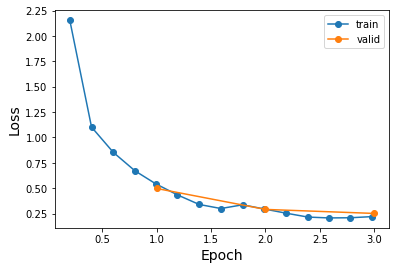

In [43]:
fig, ax = plt.subplots()
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
ax.plot(PrinterCallback.epoch, PrinterCallback.training_loss, marker='o')
ax.plot(range(1, 3+1), PrinterCallback.validation_loss, marker='o')
ax.legend(["train", "valid"])
None

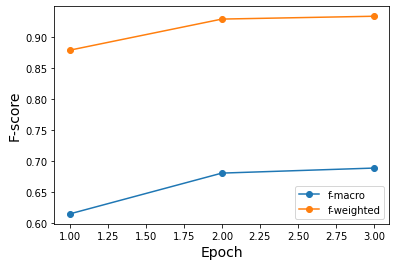

In [44]:
fig, ax = plt.subplots()
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("F-score", fontsize=14)
ax.plot(range(1, 3+1), PrinterCallback.eval_f1_macro, marker='o')
ax.plot(range(1, 3+1), PrinterCallback.eval_f1_weighted, marker='o')
ax.legend(["f-macro", "f-weighted"])
None

In [45]:
categories

['Сигареты',
 'Шоколад и кондитерские изделия',
 'Водка',
 'Вино',
 'Пиво',
 'Виски',
 'ЭСНТ и никотиносодежащие продукты',
 'Изделия хлебобулочные',
 'Чипсы, сухари, снеки',
 'Все остальное',
 'Коньяк',
 'Бренди',
 'Мясные изделия',
 'Вода питьевая',
 'Соусы',
 'Соки, Нектары',
 'Молоко и молочная продукция',
 'Рыба вяленая, соленая и несоленая',
 'Орехи',
 'Мороженое',
 'Семечки',
 'Овощи свежие',
 'Фрукты свежие',
 'Чай и кофе']

In [46]:
y_true = test["label"]

In [47]:
pred_output = trainer.predict(test)
y_pred = pred_output.predictions.argmax(-1)

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 364
  Batch size = 8


In [48]:
import seaborn
from sklearn.metrics import confusion_matrix

In [49]:
def draw_matrix(matrix, labels, mask=None, line=0., cmap="inferno", line_color="black"):
    vmax = np.max(matrix)
    if vmax < 1:
        vmax = 1
    plt.figure(figsize=(12, 9))
    ax = seaborn.heatmap(
        matrix, annot=True, vmin=0, vmax=1, mask=mask, fmt='.5g',
        cmap=cmap, linewidths=line, linecolor=line_color, cbar=False
    )
    ax.set_yticklabels(
        labels, fontsize=12, rotation=0, verticalalignment='center'
    )
    ax.set_xticklabels(
        labels, fontsize=12, rotation=90, horizontalalignment='center'
    )
    plt.show()

In [50]:
def smart_truncate(content, length=15, suffix="..."):
    if len(content) <= length:
        return content
    return ' '.join(content[:length+1].split(' ')[0:-1]) + suffix

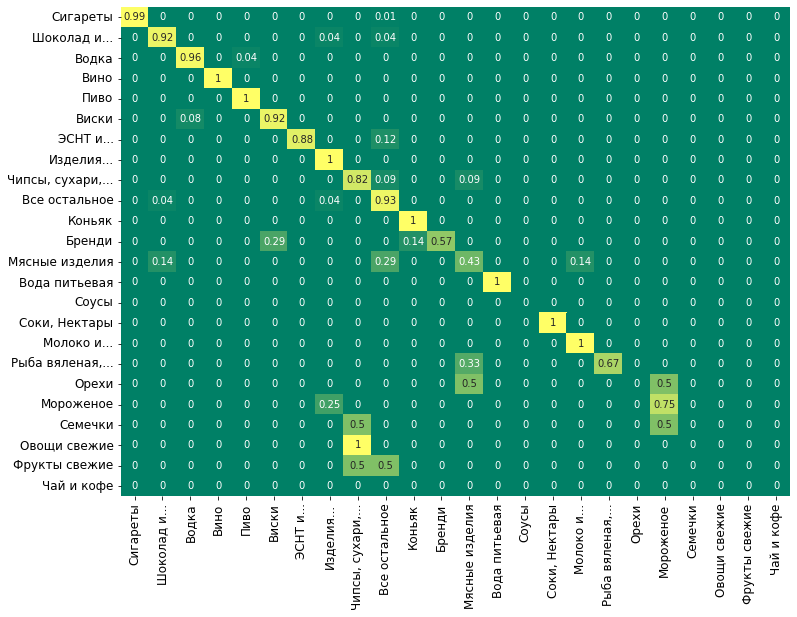

In [51]:
matrix = confusion_matrix(y_true, y_pred, labels=list(int2str.keys()), normalize="true")
matrix = np.around(matrix, decimals=2)
draw_matrix(matrix, [smart_truncate(c) for c in categories], cmap="summer")

In [52]:
path_to_saved_models = "/content/drive/My Drive/diploma"

In [53]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [54]:
!mkdir "$path_to_saved_models"

mkdir: cannot create directory ‘/content/drive/My Drive/diploma’: File exists


In [55]:
from datetime import datetime
now = datetime.now().strftime("%y-%m-%d_%H:%M:%S")

In [56]:
model_path = f"{path_to_saved_models}/model_{now}"
model_path

'/content/drive/My Drive/diploma/model_22-09-06_10:41:09'

In [57]:
model.save_pretrained(model_path)

Configuration saved in /content/drive/My Drive/diploma/model_22-09-06_10:41:09/config.json
Model weights saved in /content/drive/My Drive/diploma/model_22-09-06_10:41:09/pytorch_model.bin


In [58]:
import os
import glob

In [59]:
def get_last_file(folder):
    list_of_files = glob.glob(f"{folder}/*")
    latest_file = max(list_of_files, key=os.path.getmtime)
    return latest_file

In [60]:
last_model_path = get_last_file(path_to_saved_models)
last_model_path

'/content/drive/My Drive/diploma/model_22-09-06_10:41:09'

In [61]:
last_model = AutoModelForSequenceClassification.from_pretrained(last_model_path)

loading configuration file /content/drive/My Drive/diploma/model_22-09-06_10:41:09/config.json
Model config BertConfig {
  "_name_or_path": "/content/drive/My Drive/diploma/model_22-09-06_10:41:09",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "emb_size": 312,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 312,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18",
    "19": "LABEL_19",
    "20": "LABEL_20",
    "21": "LABEL_21",
    "22": "LABEL_22",
    "23": "LABEL_23"
  },
  "initializ

In [62]:
test_trainer = Trainer(
    model=last_model,
    compute_metrics=compute_metrics
)

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [63]:
pred_output = test_trainer.predict(test)
pred_output

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 364
  Batch size = 8


PredictionOutput(predictions=array([[-0.286836  , -0.5304966 ,  0.6486581 , ..., -0.50905305,
        -0.29685897,  0.16013452],
       [-0.5397217 , -0.47637323,  6.6756306 , ..., -0.88355917,
        -0.8260769 , -0.81854767],
       [ 0.16816866,  6.418761  , -0.98651654, ..., -1.2723348 ,
        -0.9899326 , -1.4193034 ],
       ...,
       [ 8.100003  ,  0.29562736, -0.66504955, ..., -0.5356287 ,
        -0.45508528, -0.43943515],
       [ 8.100963  ,  0.2989876 , -0.64707804, ..., -0.549004  ,
        -0.46956354, -0.4530173 ],
       [ 0.8202867 ,  0.4867634 ,  0.52104425, ..., -0.53967243,
        -0.6825249 , -0.30348584]], dtype=float32), label_ids=array([ 3,  2,  1,  3,  0,  9,  2,  0,  1,  4,  8,  0,  0,  1,  9,  3,  3,
        6,  7,  3,  0, 13,  4,  8,  9, 10,  6,  3,  0,  0,  3, 17,  2,  3,
       16,  0,  4,  9,  2,  9,  3,  2,  3,  0,  0, 16,  8,  0, 18,  5, 10,
       10, 13,  4,  3,  3,  1,  3,  4,  3,  9,  4, 16,  0,  3,  0,  0,  3,
        4,  0,  3,  0, 19, 11,  

In [64]:
def predict(model, item):
    output = model(
        input_ids=LongTensor(item["input_ids"]).unsqueeze(0).to("cuda"), 
        attention_mask=LongTensor(item["attention_mask"]).unsqueeze(0).to("cuda")
    )
    logits = output["logits"]
    label = logits[0].softmax(0).argmax().item()
    return int2str[label]

In [65]:
example = test[2]
print(example["text"])
print(predict(last_model, example))

Печенье Бантики Клубника со сливками
Шоколад и кондитерские изделия


In [66]:
@interact(Текст="")
def custom(Текст):
    text_dict = tokenizer(Текст)
    return predict(last_model, text_dict)

interactive(children=(Text(value='', description='Текст'), Output()), _dom_classes=('widget-interact',))